# <center> <b> Astrophile
# <center> <b> Business Case 1: Predict the price of the stock HPG

# Introduction

## About Data
Predict the price of the stock HPG from Hoa Phat Group in the manufacturing sector and listed on the Ho Chi Minh Stock Exchange (HOSE). <br>
**Source**: Investing.com <br>
**Period**: From January 2, 2018, to March 31, 2023 <br>
**Features**: Trading date, closing price, opening price, highest price, lowest price, trading volume, and percentage change compared to the previous day. <br>
## Goal of The Case Study
Predict the price of the stock HPG from Hoa Phat Group in the manufacturing sector and listed on the Ho Chi Minh Stock Exchange (HOSE).
## Type of Model
* ARIMA (Autoregressive integrated moving average): An econometric model
* LSTM (Long Short Term Memory): A deep learning model
## Performance Metric
* R-score
* MAPE
* RMSE

# 1. Data Pre-processing

## Import Libraries

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import optuna
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

In [3]:
%matplotlib inline

In [4]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Get the Data

In [5]:
hpg_df = pd.read_csv('HPG Historical Data.csv')
hpg_df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change']
hpg_df.head()

,Date,Close,Open,High,Low,Volume,Change
0,03/31/2023,"18,909.0","18,909.0","19,000.0","18,500.0",26.15M,0.00%
1,03/30/2023,"18,909.0","19,091.0","19,227.0","18,864.0",23.05M,0.00%
2,03/29/2023,"18,909.0","18,818.0","19,182.0","18,818.0",19.74M,0.48%
3,03/28/2023,"18,818.0","19,000.0","19,091.0","18,818.0",13.56M,-0.48%
4,03/27/2023,"18,909.0","18,545.0","19,000.0","18,500.0",22.29M,1.96%


# 2. Exploratory Data Analysis

## 2.1. Check type, missing values, categorical features

In [6]:
# Check Type & Missing Value
hpg_df.info()
hpg_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1308 non-null   object
 1   Close   1308 non-null   object
 2   Open    1308 non-null   object
 3   High    1308 non-null   object
 4   Low     1308 non-null   object
 5   Volume  1308 non-null   object
 6   Change  1308 non-null   object
dtypes: object(7)
memory usage: 71.7+ KB


(1308, 7)

## 2.2. Data Cleaning & Transformation

In [7]:
hpg_df['Close'].replace({',':''}, regex=True, inplace = True)
hpg_df['Open'].replace({',':''}, regex=True, inplace = True)
hpg_df['High'].replace({',':''}, regex=True, inplace = True)
hpg_df['Low'].replace({',':''}, regex=True, inplace = True)
hpg_df['Volume'].replace({'M':''}, regex=True, inplace = True)
hpg_df['Change'].replace({'%':''}, regex=True, inplace = True)
columns_to_convert = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change']
hpg_df[columns_to_convert] = hpg_df[columns_to_convert].astype("float")

hpg_df['Date'] = pd.to_datetime(hpg_df['Date'], format='%m/%d/%Y')
hpg_df.set_index('Date', inplace=True) # Set the 'Date' column as the index

In [8]:
# Chạy 1 lần thôi nhé
price_columns = ['Close', 'Open', 'High', 'Low']

# Chia các cột giá cho 1000
hpg_df[price_columns] = hpg_df[price_columns]/1000
hpg_df.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2023-03-31,18.909,18.909,19.000,18.500,26.15,0.00
2023-03-30,18.909,19.091,19.227,18.864,23.05,0.00
2023-03-29,18.909,18.818,19.182,18.818,19.74,0.48
2023-03-28,18.818,19.000,19.091,18.818,13.56,-0.48
2023-03-27,18.909,18.545,19.000,18.500,22.29,1.96


In [9]:
hpg_df.to_csv('tinydata_HPG.csv', index=False)

In [10]:
hpg_df['Fluctuation'] = hpg_df['High']-hpg_df['Low']

## 2.3. EDA

In [11]:
hpg_df.describe()

,Close,Open,High,Low,Volume,Change,Fluctuation
count,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000
mean,19.249098,19.261465,19.541895,18.986828,24.253647,0.064274,0.555067
std,9.780770,9.809761,9.929208,9.676521,15.021485,2.374579,0.410570
min,7.411800,7.000000,7.640600,6.977200,3.320000,-7.000000,0.045800
25%,11.605100,11.613900,11.736650,11.445475,13.192500,-1.132500,0.251600
50%,14.957300,14.944750,15.183600,14.719000,21.025000,0.000000,0.440000
75%,24.003825,24.081000,24.339325,23.621425,31.202500,1.222500,0.731500
max,43.895800,43.895800,44.198500,43.517400,109.620000,6.940000,3.178600


In [12]:
corr = hpg_df.corr(method='pearson')
corr

,Close,Open,High,Low,Volume,Change,Fluctuation
Close,1.000000,0.998969,0.999572,0.999519,0.475206,0.015699,0.616456
Open,0.998969,1.000000,0.999560,0.999567,0.473634,-0.021391,0.615019
High,0.999572,0.999560,1.000000,0.999455,0.482282,-0.004093,0.628298
Low,0.999519,0.999567,0.999455,1.000000,0.465612,-0.004264,0.602275
Volume,0.475206,0.473634,0.482282,0.465612,1.000000,-0.001882,0.689715
Change,0.015699,-0.021391,-0.004093,-0.004264,-0.001882,1.000000,0.001500
Fluctuation,0.616456,0.615019,0.628298,0.602275,0.689715,0.001500,1.000000


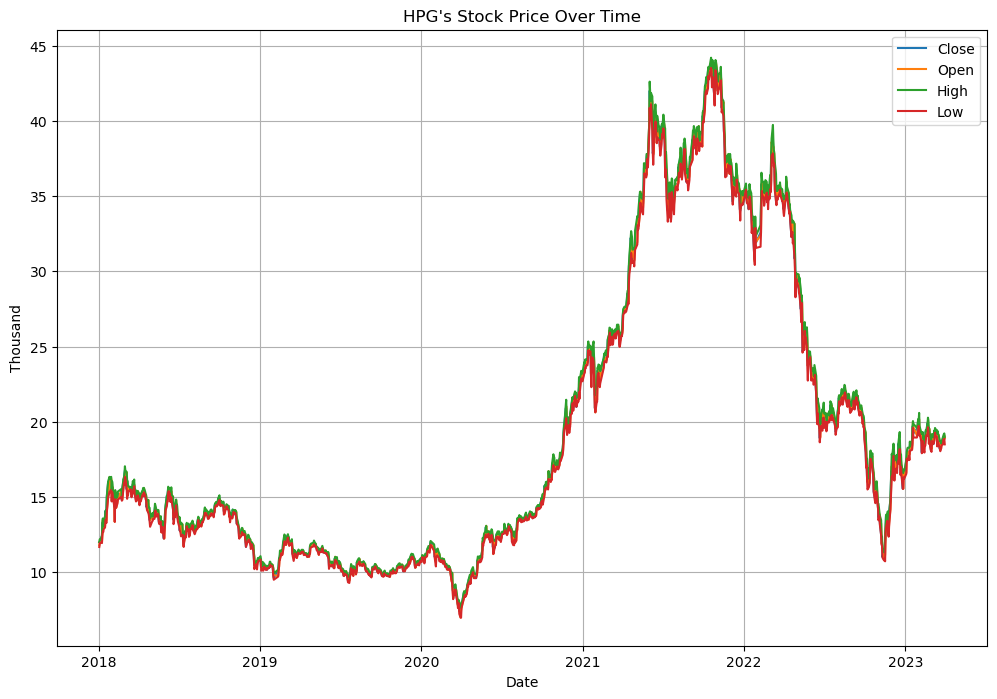

In [13]:
# Plot line charts for all columns
plt.figure(figsize=(12, 8))
for column in hpg_df[price_columns]:
    plt.plot(hpg_df.index, hpg_df[column], label=column)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Thousand')
plt.title("HPG's Stock Price Over Time")
plt.legend()
plt.grid(True)
plt.show()

The Line chart demonstrates that:
* Non-seasional
* Non-trended

C:\Users\yen nhi\AppData\Local\Temp\ipykernel_11640\1820043685.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)
C:\Users\yen nhi\AppData\Local\Temp\ipykernel_11640\1820043685.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hpg_df[col])
C:\Users\yen nhi\AppData\Local\Temp\ipykernel_11640\1820043685.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibilit

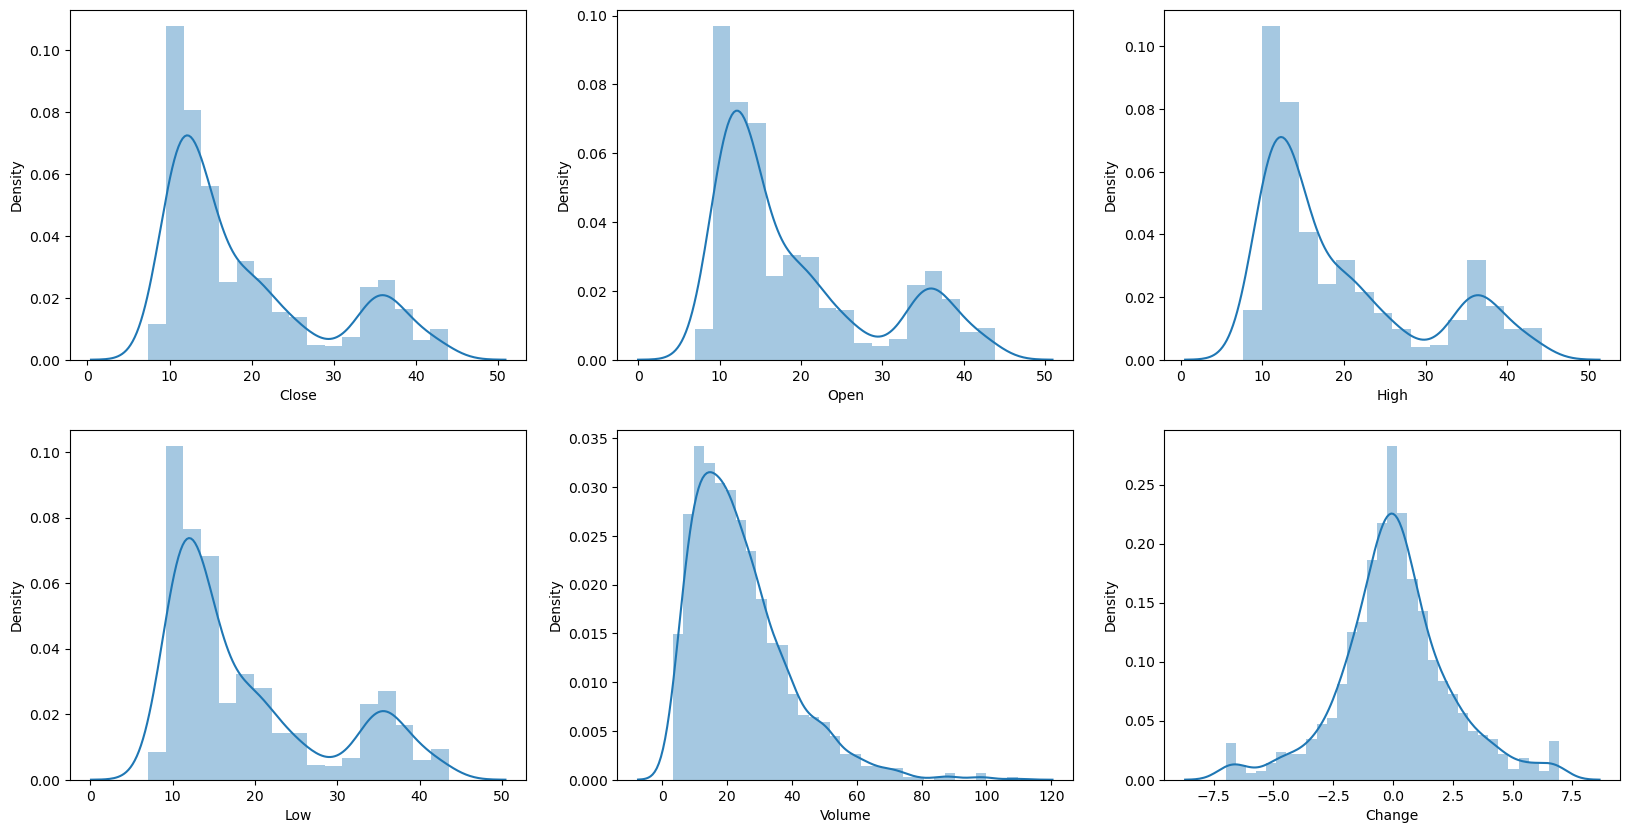

In [14]:
features = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change'] 
  
plt.subplots(figsize=(20,10)) 
  
for i, col in enumerate(features): 
    plt.subplot(2,3,i+1) 
    sns.distplot(hpg_df[col]) 
plt.show()

C:\Users\yen nhi\AppData\Local\Temp\ipykernel_11640\3256323946.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


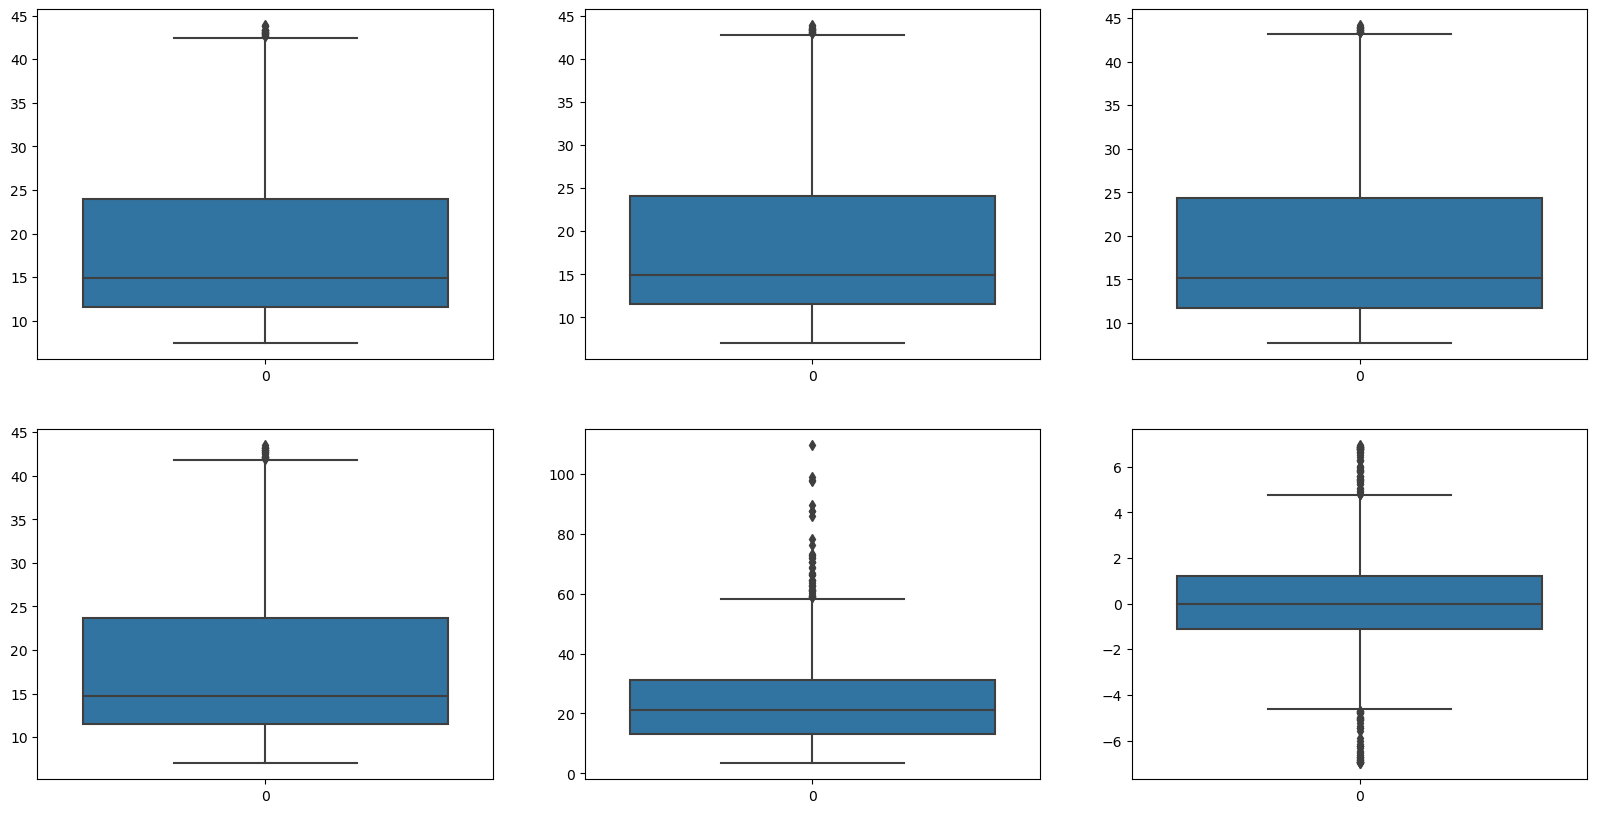

In [15]:
plt.subplots(figsize=(20,10)) 
for i, col in enumerate(features): 
    plt.subplot(2,3,i+1) 
    sns.boxplot(hpg_df[col]) 
plt.show()

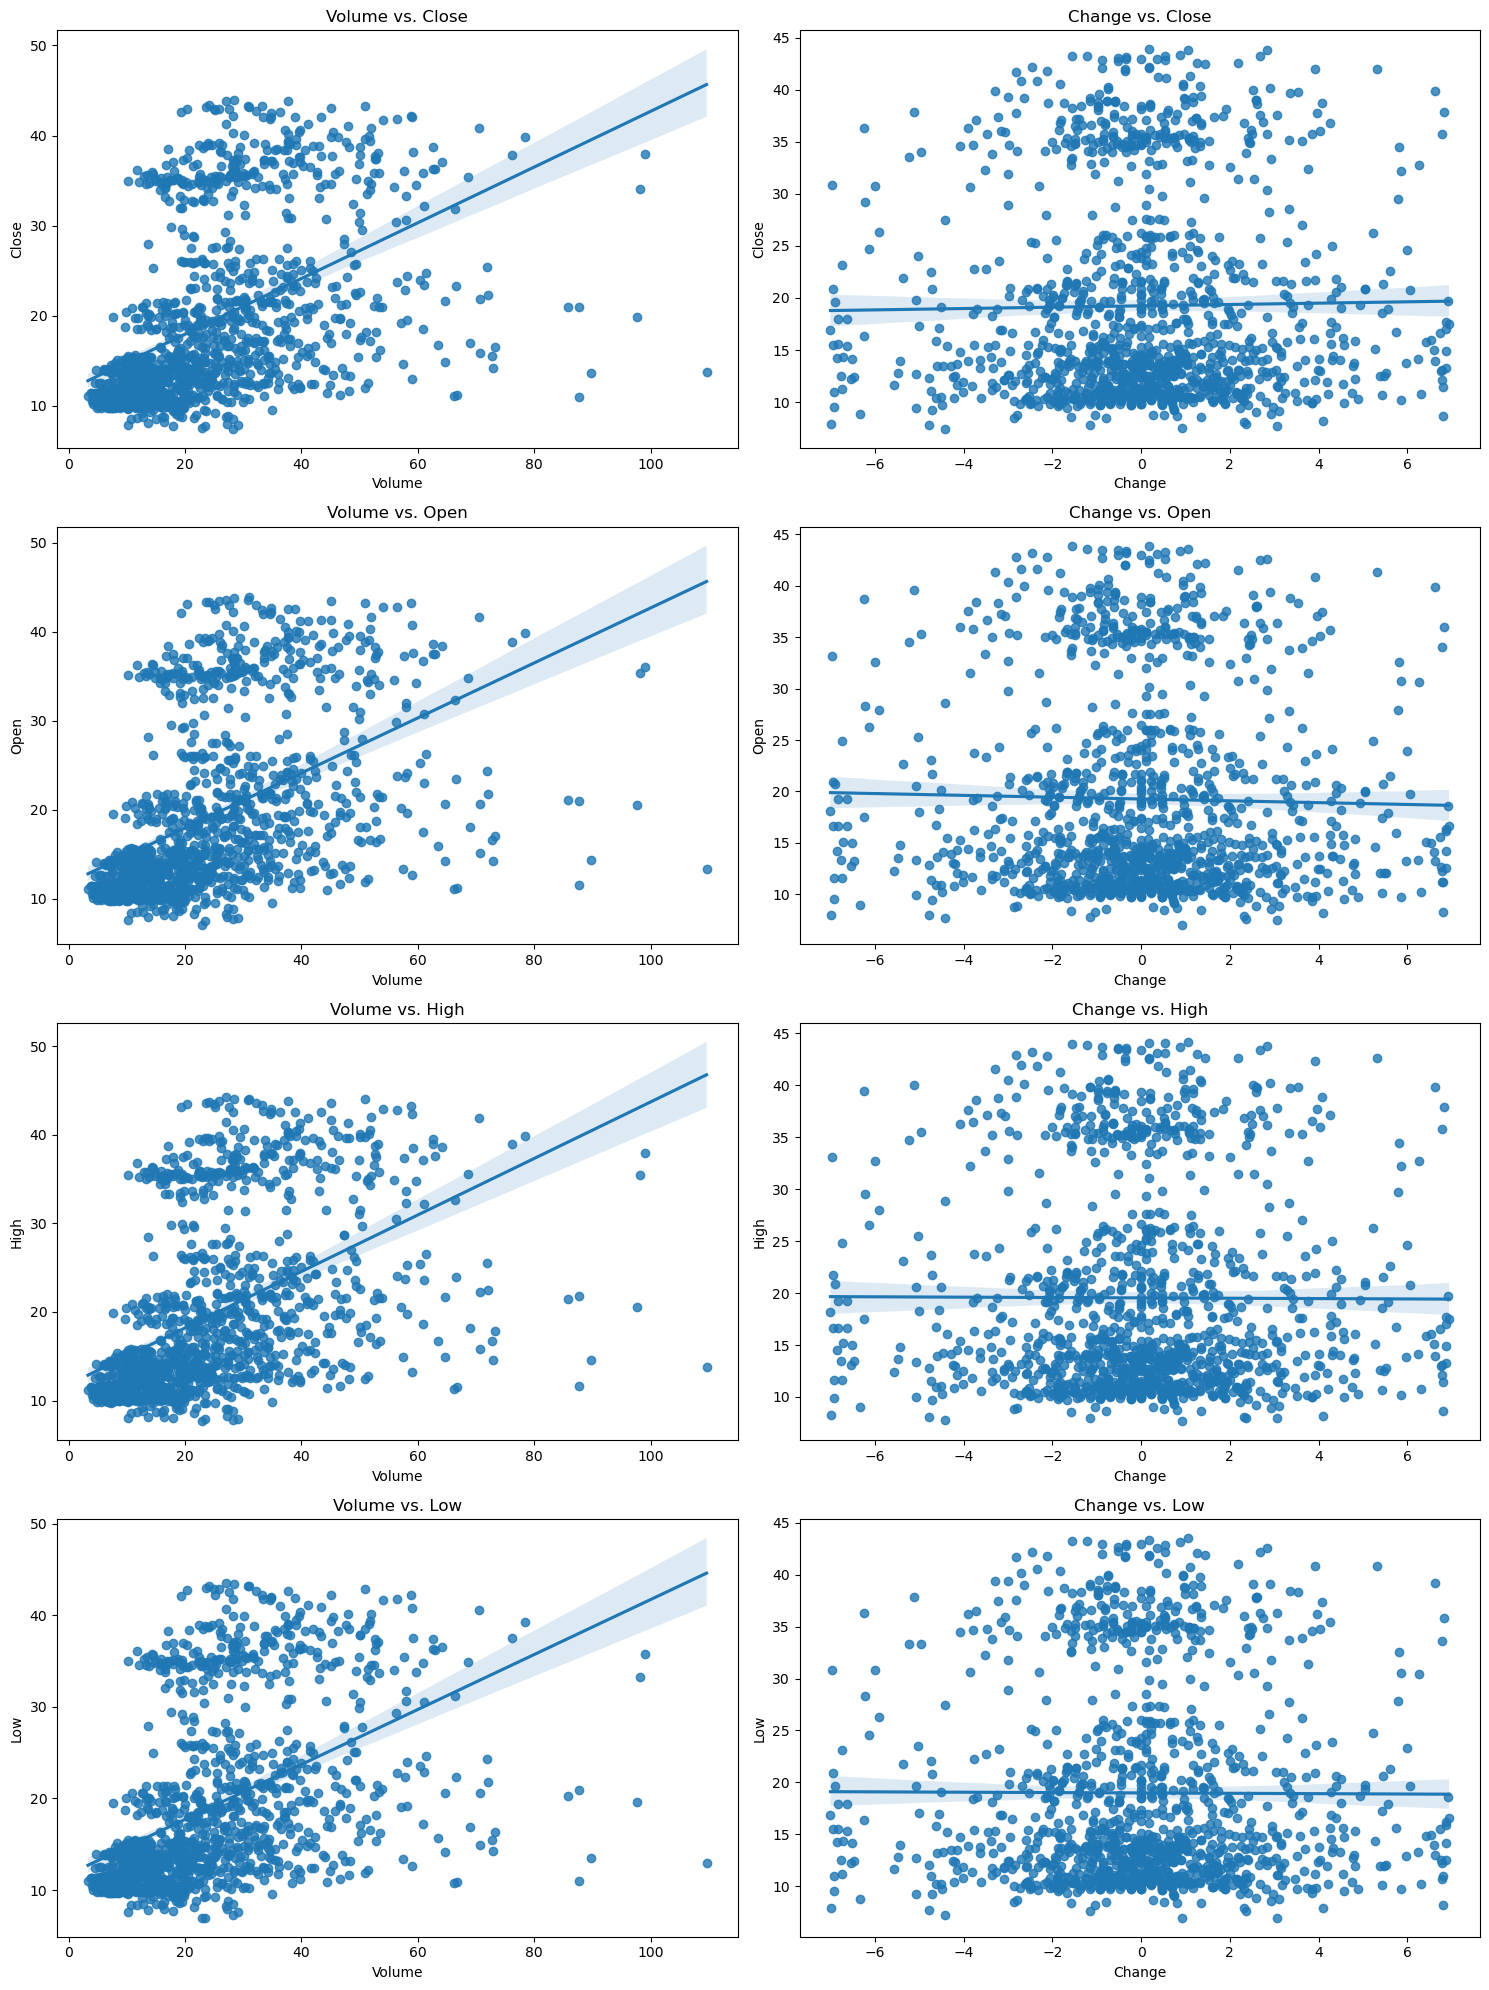

In [16]:
# Correcting the number of subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Plot regression plots for Volume vs. each price column
for i, column in enumerate(price_columns):
    sns.regplot(x=hpg_df['Volume'], y=hpg_df[column], ax=axes[i, 0])
    axes[i, 0].set_title(f'Volume vs. {column}')

# Plot regression plots for Change vs. each price column
for i, column in enumerate(price_columns):
    sns.regplot(x=hpg_df['Change'], y=hpg_df[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Change vs. {column}')

# Adjust layout
plt.tight_layout()
plt.show()

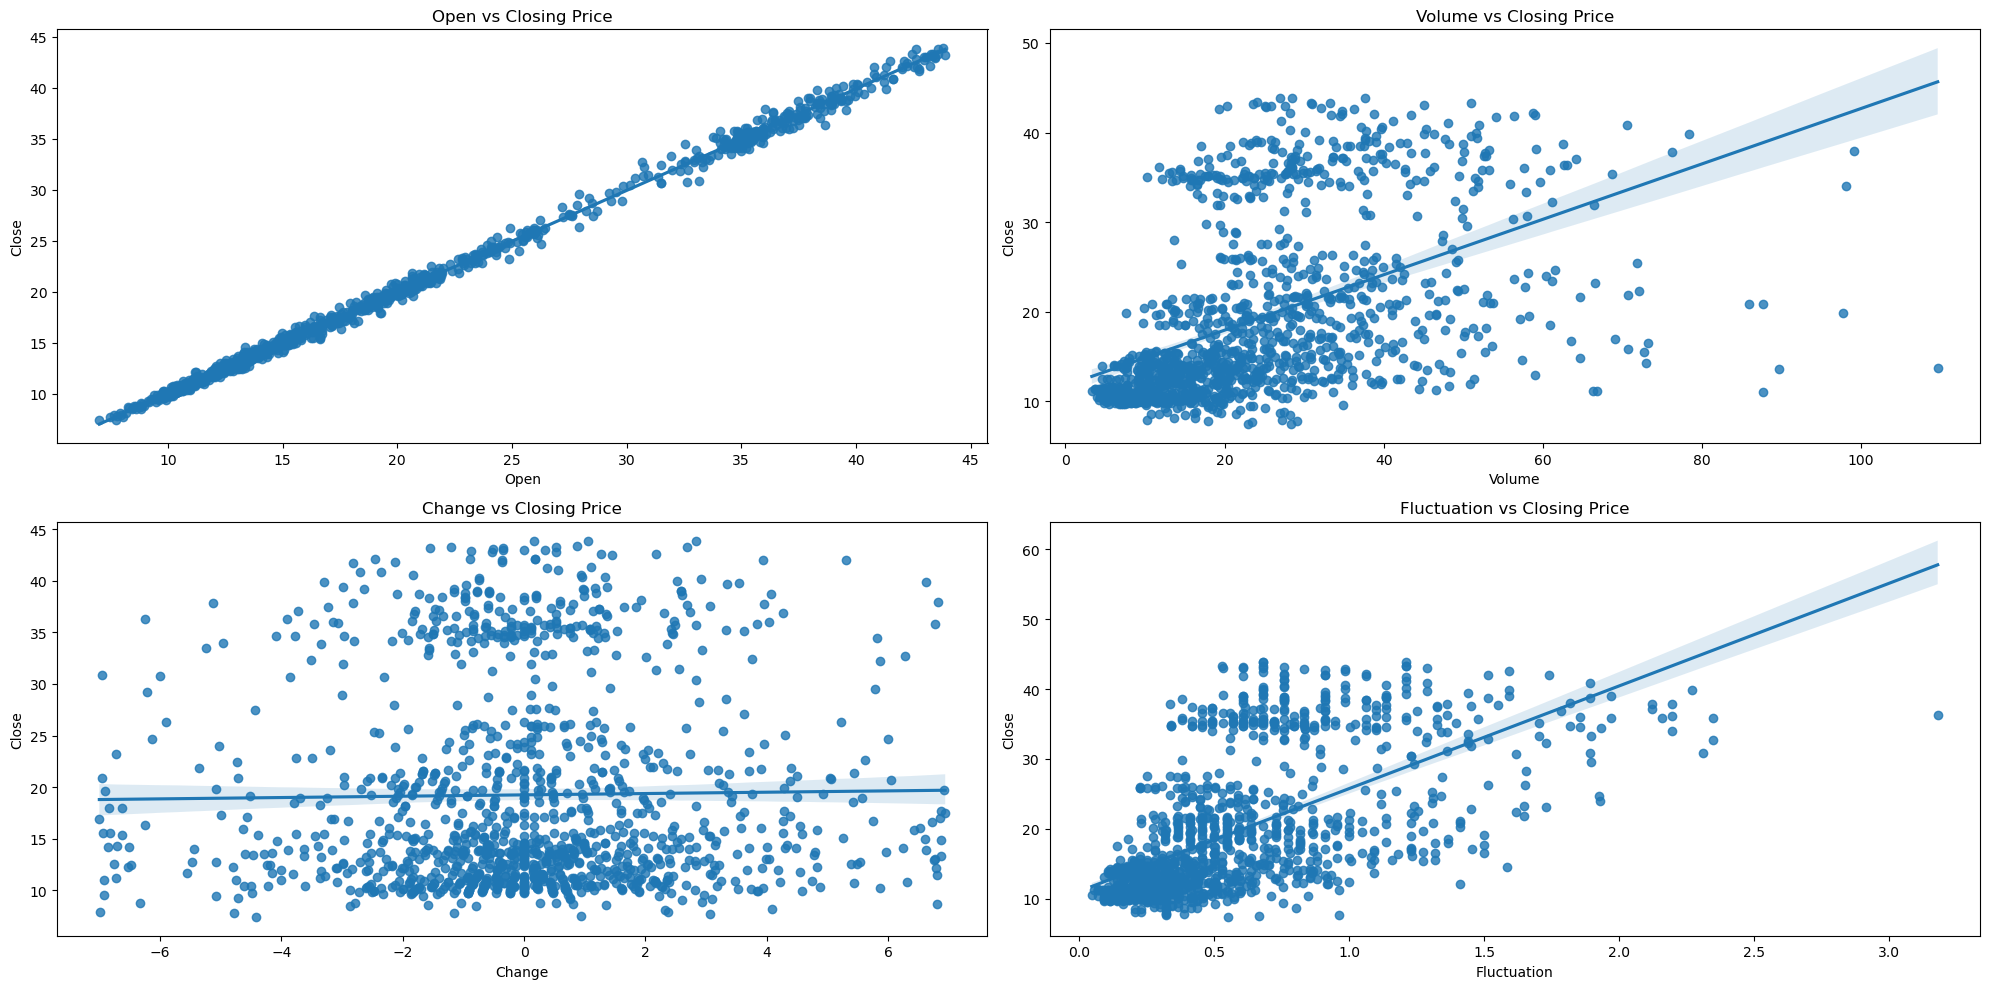

In [17]:
# Define the features
features = ['Open', 'Volume', 'Change', 'Fluctuation']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Loop through features and plot regression plots
for i, col in enumerate(features):
    row, col_pos = divmod(i, 2)
    sns.regplot(x=hpg_df[col], y=hpg_df['Close'], ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'{col} vs Closing Price')

# Adjust layout
plt.tight_layout()
plt.show()

# 3. Long Short Term Memory Model (LSTM)

## 3.1. Preparing

In [18]:
# Splitting the data
training_data = hpg_df[:'2022-02-28']
testing_data = hpg_df['2022-03-01':]
# Display the shapes of the resulting datasets
training_data.shape, testing_data.shape

((1035, 7), (273, 7))

In [19]:
# Defining the features (X) and target (y) columns
features = ['Open', 'Volume', 'Change', 'Fluctuation']
target = 'Close'

# Selecting the features and target for training and testing sets
X_train = training_data[features]
y_train = training_data[target]

X_test = testing_data[features]
y_test = testing_data[target]

In [38]:
# StandardScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (LSTM expects 3D input)
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

## 3.2. Hyper-parameter Tuning

In [39]:
# Define LSTM model
def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [40]:
# Optuna objective function
def objective(trial):
    units = trial.suggest_int('units', 10, 100)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    model = KerasRegressor(build_fn=create_lstm_model, units=units, dropout_rate=dropout_rate, epochs=50, batch_size=32, verbose=0)
    model.fit(X_train_lstm, y_train)
    score = model.score(X_test_lstm, y_test)
    return score

# Run Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Best parameters from Optuna
best_params = study.best_params
print("Best parameters found by Optuna:", best_params)

[I 2024-06-17 11:11:45,248] A new study created in memory with name: no-name-49c53fc5-1273-491c-a59f-8cdbf5dce5cc
C:\Users\yen nhi\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\yen nhi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-06-17 11:12:00,332] Trial 0 finished with value: 0.8937792243130962 and parameters: {'units': 31, 'dropout_rate': 0.37587182617619763}. Best is trial 0 with value: 0.8937792243130962.
C:\Users\yen nhi\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which poin

Best parameters found by Optuna: {'units': 31, 'dropout_rate': 0.37587182617619763}


## 3.3. Model Training with Best Parameters

In [41]:
# Build and train the LSTM model with best parameters
best_model = create_lstm_model(units=best_params['units'], dropout_rate=best_params['dropout_rate'])
history = best_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Predict on test data
y_pred = best_model.predict(X_test_lstm)

Epoch 1/50


C:\Users\yen nhi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 467.1521 - val_loss: 475.2833
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 384.2746 - val_loss: 253.3675
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 228.6187 - val_loss: 177.0161
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 173.7941 - val_loss: 149.1187
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 159.6319 - val_loss: 128.6461
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 142.7824 - val_loss: 113.2098
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 134.8447 - val_loss: 100.5975
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 133.8933 - val_loss: 90.5477
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 121.1639 - val_loss: 82.3327
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 121.5752 - val_loss: 76.0912
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 120.6351 - val_loss: 71.0743
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1

## 3.4. Evaluation

In [42]:
# Calculate metrics
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

In [43]:
# Create a DataFrame to display the results
metrics = {
    'Metric': ['R-squared', 'MAPE', 'RMSE'],
    'Value': [r2, mape, rmse]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Value
0,R-squared,0.921211
1,MAPE,0.069128
2,RMSE,1.787683


# 4. Autoregressive integrated moving average (ARIMA)

## 4.1. Preparing

In [22]:
# Perform first-order differencing
diff_y_train = y_train.diff().dropna()
# Dickey-Fuller test
adf_result = adfuller(diff_y_train)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -5.169722521388703
p-value: 1.0133645318882408e-05


## 4.2. Model Building and Selection

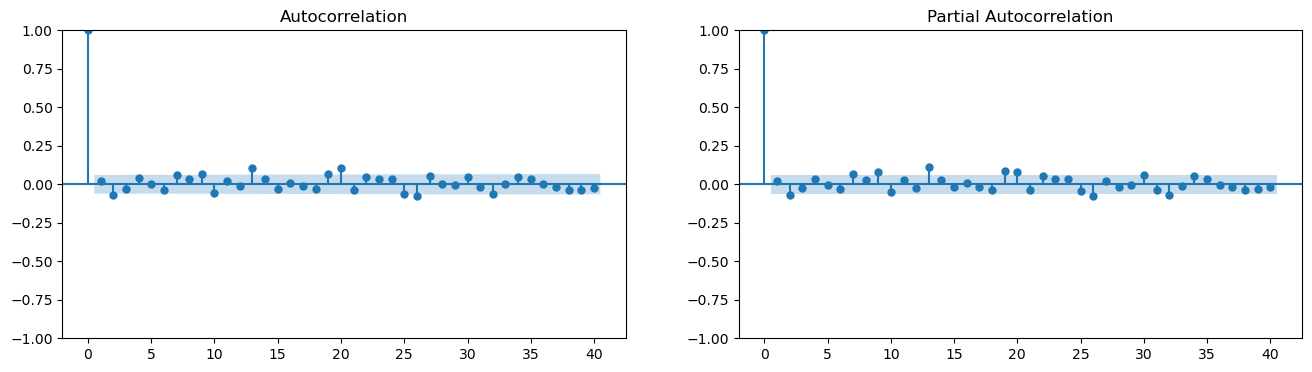

In [24]:
# Plotting ACF and PACF to determine p and q
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sm.graphics.tsa.plot_acf(diff_y_train, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_y_train, lags=40, ax=ax[1])
plt.show()

In [25]:
# Based on ACF and PACF plots, we can choose p and q values
p = 2
d = 1
q = 2
# Building the ARIMAX model
model = ARIMA(endog=y_train, exog=X_train, order=(p, d, q))
fitted_model = model.fit()

C:\Users\yen nhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\yen nhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\yen nhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\yen nhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\yen nhi\anaconda3

## 4.3. Predictive and Evaluation

In [26]:
# Predicting the stock prices
forecast = fitted_model.forecast(steps=len(X_test), exog=X_test)

C:\Users\yen nhi\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [27]:
# Evaluating the model
r2 = r2_score(y_test, forecast)
mape = mean_absolute_percentage_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))

# Create a DataFrame to display the results
metrics = {
    'Metric': ['R-squared', 'MAPE', 'RMSE'],
    'Value': [r2, mape, rmse]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Value
0,R-squared,0.996112
1,MAPE,0.012974
2,RMSE,0.397135


# Conclusion

## Forecasted results using LSTM model

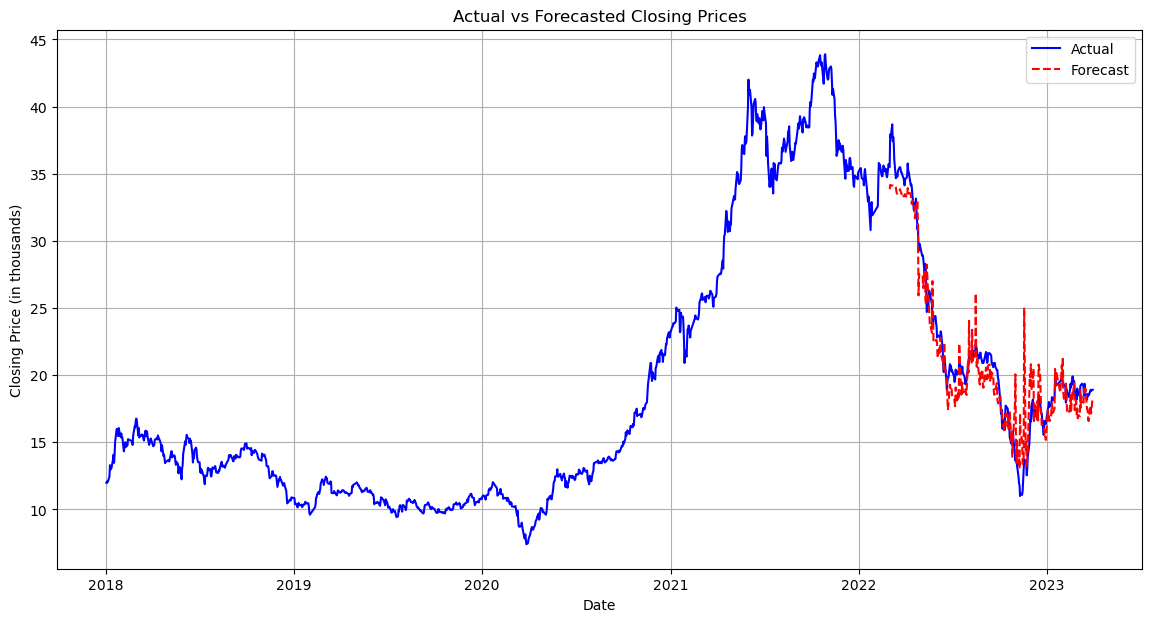

In [47]:
# Plotting the actual values and forecasted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(hpg_df.index, hpg_df.loc['2018-01-02':'2023-03-31', 'Close'], label='Actual', color='blue')

# Plot forecasted values
plt.plot(testing_data.index, y_pred, label='Forecast', color='red', linestyle='--')

# Adding titles and labels
plt.title('Actual vs Forecasted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price (in thousands)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

## Forecasted results using ARIMAX model

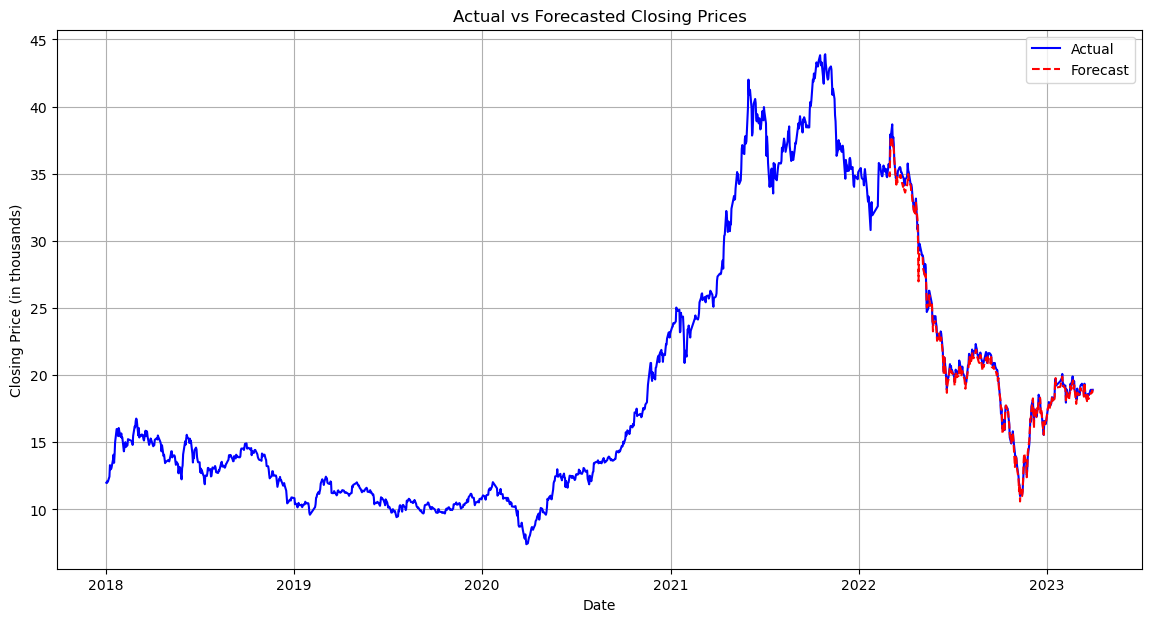

In [28]:
# Plotting the actual values and forecasted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(hpg_df.index, hpg_df.loc['2018-01-02':'2023-03-31', 'Close'], label='Actual', color='blue')

# Plot forecasted values
plt.plot(testing_data.index, forecast, label='Forecast', color='red', linestyle='--')

# Adding titles and labels
plt.title('Actual vs Forecasted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price (in thousands)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()